<a href="https://colab.research.google.com/github/liuyao12/Ranger-Mish-ImageWoof-5/blob/master/Woof_128_twist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet with a Twist

> ConvTwist + Mish + MaxBlurPool + restrick

# setup and imports

In [2]:
!pip install git+https://github.com/ayasyrev/model_constructor

  Cloning https://github.com/ayasyrev/model_constructor to /tmp/pip-req-build-51qv565a
  Running command git clone -q https://github.com/ayasyrev/model_constructor /tmp/pip-req-build-51qv565a
  Created wheel for model-constructor: filename=model_constructor-0.1.1-cp36-none-any.whl size=21649 sha256=ad3b396cd1c904813a6336b3b37d56c4769f883882d8c4bdda5d97edacc3a246
  Stored in directory: /tmp/pip-ephem-wheel-cache-kktkql2k/wheels/5b/92/65/8093a307d5802f41f4a8776b40bc12b558e75a2a906ae8b683
Successfully built model-constructor


In [3]:
!pip install git+https://github.com/ayasyrev/imagenette_experiments

  Cloning https://github.com/ayasyrev/imagenette_experiments to /tmp/pip-req-build-c4wfmfvk
  Running command git clone -q https://github.com/ayasyrev/imagenette_experiments /tmp/pip-req-build-c4wfmfvk
     |████████████████████████████████| 143kB 8.5MB/s 
  Created wheel for imagenette-experiments: filename=imagenette_experiments-0.0.1-cp36-none-any.whl size=12379 sha256=4540bc23d3bc2cca36e9db445e1955dabf9c3582c260d29178a8576abc6cffcd
  Stored in directory: /tmp/pip-ephem-wheel-cache-s_e9mi3s/wheels/af/99/98/2212941f45a18bf6d191f56c39e3569138414560c76defc0d4
Successfully built imagenette-experiments


In [0]:
from imagenette_experiments.train_utils import *

In [0]:
from kornia.contrib import MaxBlurPool2d

In [0]:
from fastai.basic_train import *
from fastai.vision import *
# from fastai.script import *
from model_constructor.net import *
from model_constructor.layers import SimpleSelfAttention, ConvLayer

# Twist

In [0]:
class ConvTwist(nn.Module):  # replacing 3x3 Conv2d
    def __init__(self, ni, nf, stride=1, init=0.7):
        super(ConvTwist, self).__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv_x = nn.Conv2d(ni, nf, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv_y = nn.Conv2d(ni, nf, kernel_size=3, stride=stride, padding=1, bias=False)
        self.symmetrize(self.conv_x.weight)  # make conv_x a "first-order operator" by symmetrizing it
        self.conv_y.weight.data = self.conv_x.weight.transpose(2,3).flip(3)  # make conv_y a 90 degree rotation of conv_x
        self.center_x = nn.Parameter(torch.Tensor(nf), requires_grad=True)
        self.center_y = nn.Parameter(torch.Tensor(nf), requires_grad=True)
        # self.center_x.data.uniform_(-init, init)
        # self.center_y.data.uniform_(-init, init)
        self.center_x.data.normal_(0, init)
        self.center_y.data.normal_(0, init)
        self.same = ni == nf and stride == 1

    def symmetrize(self, conv_wt):
        conv_wt.data = (conv_wt - conv_wt.flip(2).flip(3)) / 2
        
    def forward(self, inpt):
        out = self.conv(inpt)
        _, _, h, w = out.size()
        XX = torch.from_numpy(np.indices((1,h,w))[2]*2/w-1).type(out.dtype).to(out.device) + self.center_x.view(-1,1,1)
        YY = torch.from_numpy(np.indices((1,h,w))[1]*2/h-1).type(out.dtype).to(out.device) + self.center_y.view(-1,1,1)
        self.symmetrize(self.conv_x.weight)
        self.symmetrize(self.conv_y.weight)
        out += XX * self.conv_x(inpt) + YY * self.conv_y(inpt)
        # if self.same:
        #     out += inpt
        #     for _ in range(2):
        #         out += self.conv(out) + XX * self.conv_x(out) + YY * self.conv_y(out)
        #     out -= inpt
        return out

# ResBlock

In [0]:
class NewLayer(nn.Sequential):
    """Basic conv layers block"""
    def __init__(self, ni, nf, ks=3, stride=1,
            act=True,  act_fn=nn.ReLU(inplace=True),
            bn_layer=True, bn_1st=True, zero_bn=False,
            padding=None, bias=False, groups=1, **kwargs):

        if padding==None: padding = ks//2
#         layers = [('conv', nn.Conv2d(ni, nf, ks, stride=stride, 
#                 padding=padding, bias=bias, groups=groups))]
        if ks == 1:  layers = [('conv', nn.Conv2d(ni, nf, ks, stride=stride,bias=bias))]
        else:  layers = [('conv_twist', ConvTwist(ni, nf, stride=stride))]

        act_bn = [('act_fn', act_fn)] if act else []
        if bn_layer:
            bn = nn.BatchNorm2d(nf)
            nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
            act_bn += [('bn', bn)]
        if bn_1st: act_bn.reverse()
        layers += act_bn
        super().__init__(OrderedDict(layers))

In [0]:
class NewResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1, 
                 conv_layer=ConvLayer, act_fn=act_fn, bn_1st=True,
                 pool=nn.AvgPool2d(2, ceil_mode=True), sa=False,sym=False, zero_bn=True):
        nf,ni = nh*expansion,ni*expansion
        conv_layer = NewLayer
        self.reduce = noop if stride==1 else pool
        layers  = [(f"conv_0", conv_layer(ni, nh, 3, stride=stride, act_fn=act_fn, bn_1st=bn_1st)),
                   (f"conv_1", conv_layer(nh, nf, 3, zero_bn=zero_bn, act=False, bn_1st=bn_1st))
        ] if expansion == 1 else [
                   (f"conv_0",conv_layer(ni, nh, 1, act_fn=act_fn, bn_1st=bn_1st)),
                   (f"conv_1",conv_layer(nh, nh, 3, stride=1, act_fn=act_fn, bn_1st=bn_1st)), #!!!
                   (f"conv_2",conv_layer(nh, nf, 1, zero_bn=zero_bn, act=False, bn_1st=bn_1st))
        ]
        if sa: layers.append(('sa', SimpleSelfAttention(nf,ks=1,sym=sym)))
        self.convs = nn.Sequential(OrderedDict(layers))
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False, bn_1st=bn_1st)
        self.merge = act_fn

    def forward(self, x): 
        o = self.reduce(x)
        return self.merge(self.convs(o) + self.idconv(o))

In [0]:
# hide
NewResBlock(4, 64, 128)

# Model Constructor

In [0]:
pool = MaxBlurPool2d(3, True)

In [0]:
model = Net(c_out=10, layers=[3,4,6,3], expansion=4)

In [0]:
model.block = NewResBlock
model.pool = pool
model.stem_pool = pool
model.stem_sizes = [3,32,64,64]
model.act_fn= Mish()
model.sa = True

# Params

In [0]:
lr = 0.008
epochs = 5
moms = (0.95,0.95)
start_pct = 0.72
size=128
bs=32
mixup=0.5

# Lr find

In [15]:
learn = get_learn(model=model,size=size,bs=bs)

data path   /root/.fastai/data/imagewoof2


/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:457: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


Learn path /root/.fastai/data/imagewoof2


In [0]:
learn.lr_find()

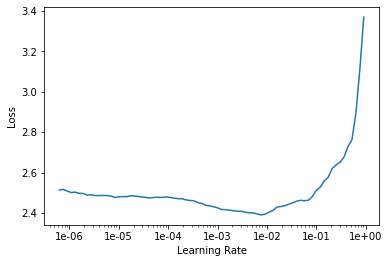

In [0]:
learn.recorder.plot()

# epochs 5 lr 0.008 750-754-749



In [0]:
lr = 4e-3
bs = 64
epochs = 200

In [15]:
learn = get_learn(model=model,size=size,bs=bs,mixup=mixup)
learn.fit_fc(epochs, lr, moms, start_pct)

data path   /root/.fastai/data/imagewoof2
Learn path /root/.fastai/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.159978,2.236045,0.292441,0.837109,01:33
1,1.984344,1.767844,0.426826,0.899211,01:34
2,1.877614,1.828431,0.418936,0.867905,01:33
3,1.771348,1.398678,0.617969,0.939934,01:33
4,1.697192,1.554161,0.538559,0.930517,01:33
5,1.636745,1.221899,0.705778,0.963095,01:33
6,1.589605,1.317774,0.655383,0.948587,01:33
7,1.548641,1.130645,0.740137,0.966913,01:33
8,1.513009,1.226184,0.689743,0.959023,01:33
9,1.489157,1.063726,0.770425,0.972003,01:33


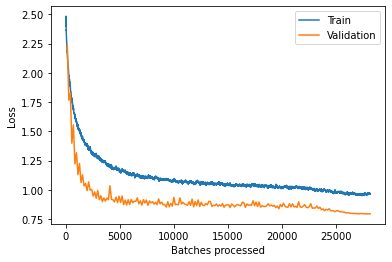

In [16]:
  learn.recorder.plot_losses()

In [17]:
for i in range(200):
    print('epoch {} {}'.format(i, learn.recorder.metrics[i][0].item()))

epoch 0 0.29244083166122437
epoch 1 0.4268261790275574
epoch 2 0.4189361035823822
epoch 3 0.6179689764976501
epoch 4 0.5385594367980957
epoch 5 0.7057775259017944
epoch 6 0.6553830504417419
epoch 7 0.7401374578475952
epoch 8 0.689742922782898
epoch 9 0.770425021648407
epoch 10 0.7307202816009521
epoch 11 0.7851870656013489
epoch 12 0.7660982608795166
epoch 13 0.8058030009269714
epoch 14 0.7576991319656372
epoch 15 0.7981674671173096
epoch 16 0.7981674671173096
epoch 17 0.8182743787765503
epoch 18 0.8080936670303345
epoch 19 0.828709602355957
epoch 20 0.8032578229904175
epoch 21 0.8381267786026001
epoch 22 0.8172562718391418
epoch 23 0.836090624332428
epoch 24 0.8205650448799133
epoch 25 0.8340544700622559
epoch 26 0.836090624332428
epoch 27 0.8368541598320007
epoch 28 0.784932553768158
epoch 29 0.8365996479988098
epoch 30 0.8297276496887207
epoch 31 0.8396538496017456
epoch 32 0.8353270292282104
epoch 33 0.8498345613479614
epoch 34 0.8261644244194031
epoch 35 0.8465258479118347
epoch 3

In [24]:
for name, param in learn.model.body.named_parameters():
    if 'center' in name:
        print(name, param.mean().item(), param.std().item())

l_0.bl_0.convs.conv_1.conv_twist.center_x 0.014435365796089172 1.0631141662597656
l_0.bl_0.convs.conv_1.conv_twist.center_y -0.16158731281757355 1.0188487768173218
l_0.bl_1.convs.conv_1.conv_twist.center_x 0.09942206740379333 0.9198014736175537
l_0.bl_1.convs.conv_1.conv_twist.center_y -0.11900509893894196 0.9382641315460205
l_0.bl_2.convs.conv_1.conv_twist.center_x 0.06401363015174866 0.7097824215888977
l_0.bl_2.convs.conv_1.conv_twist.center_y -0.1451396644115448 0.6704322695732117
l_1.bl_0.convs.conv_1.conv_twist.center_x -0.1042574942111969 1.014644980430603
l_1.bl_0.convs.conv_1.conv_twist.center_y 0.009049192070960999 1.047663927078247
l_1.bl_1.convs.conv_1.conv_twist.center_x 0.055150650441646576 0.8655534982681274
l_1.bl_1.convs.conv_1.conv_twist.center_y -0.14786618947982788 0.8987410664558411
l_1.bl_2.convs.conv_1.conv_twist.center_x -0.04527495056390762 0.8420585989952087
l_1.bl_2.convs.conv_1.conv_twist.center_y -0.20022760331630707 1.004878282546997
l_1.bl_3.convs.conv_1.c

Plotting the "centers" at the end of training — supposedly these are the points around which the `ConvTwist` is making a tiny rotation or dilation. I don't know what to make of these.

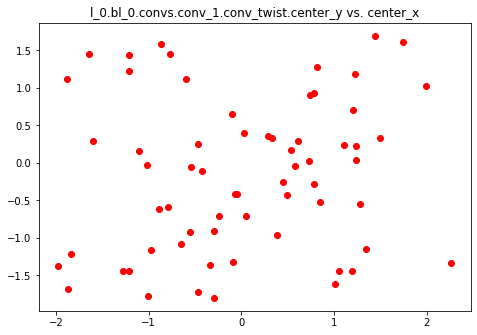

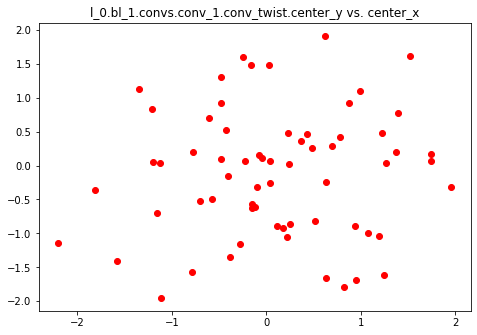

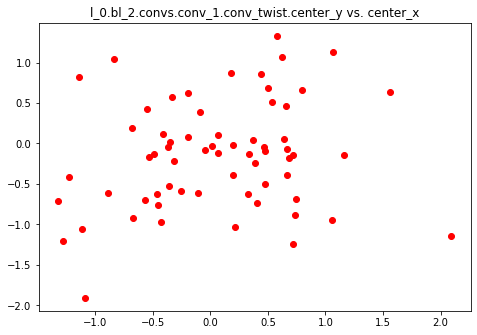

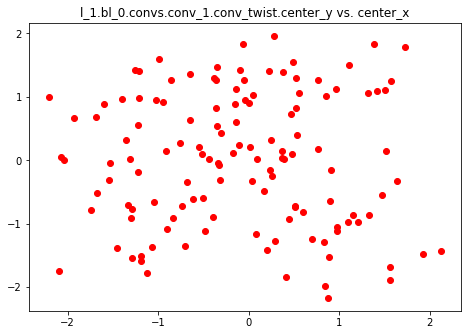

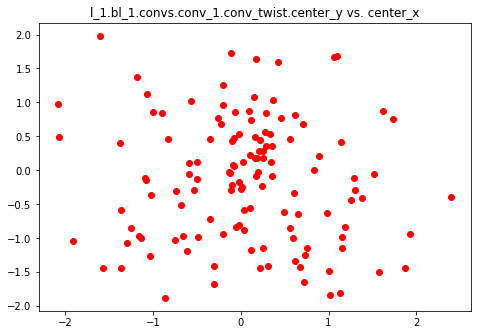

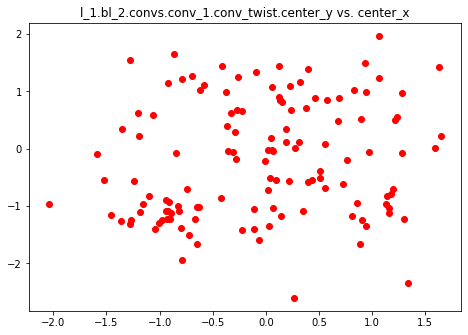

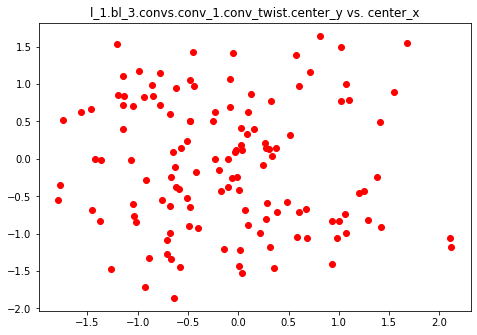

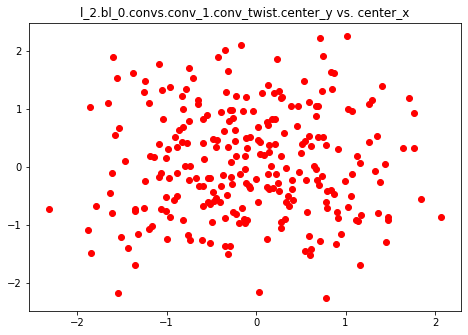

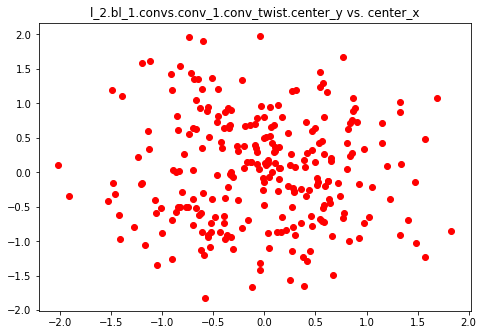

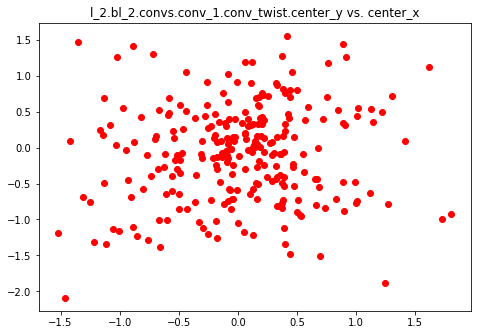

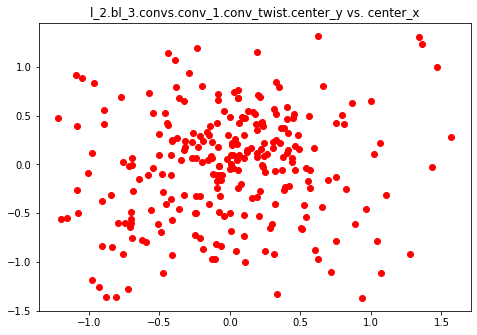

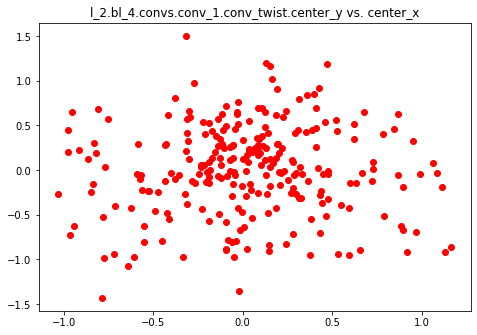

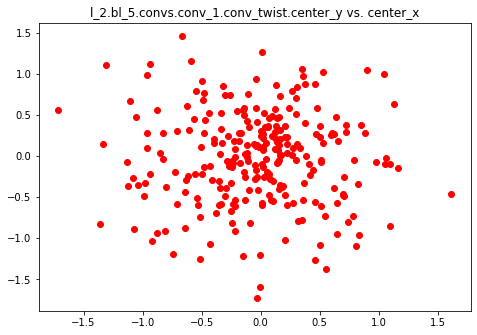

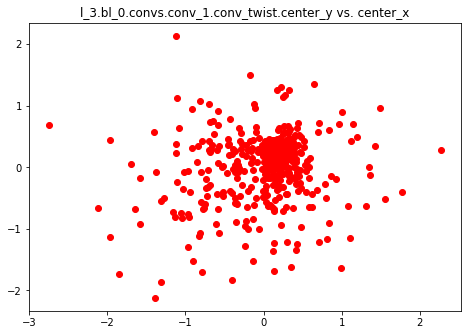

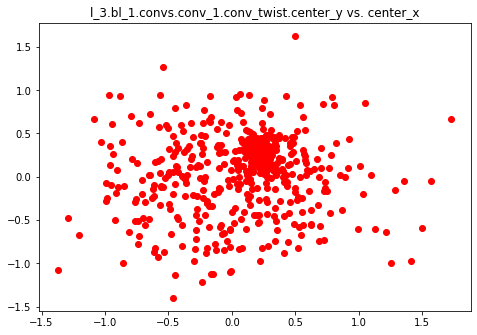

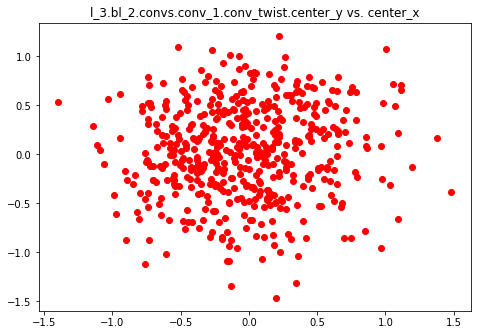

In [22]:
data = [None, None]
for name, param in learn.model.body.named_parameters():
    if 'center_x' in name:
        data[0] = param
    if 'center_y' in name:
        data[1] = param
        center_x = [x.item() for x in data[0]]
        center_y = [y.item() for y in data[1]]
        fig=plt.figure()
        ax=fig.add_axes([0,0,1,1])
        ax.scatter(center_x, center_y, color='r')
        ax.set_title(name + ' vs. center_x')
        plt.show()

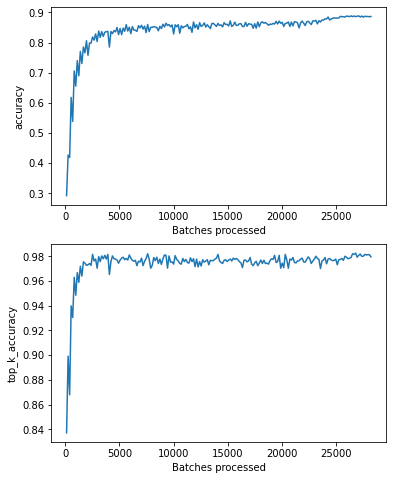

In [23]:
learn.recorder.plot_metrics()